In [1]:
import sys
from cnmf import cNMF
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from starcat import starCAT

This notebook provides example code for building a new starCAT reference by running cNMF on an example dataset. Please refer to https://github.com/dylkot/cNMF for more detailed tutorials using cNMF.

## Download the reference data and copy it to the directory ./example_PBMC

In [ ]:
if not os.path.exists('example_PBMC'):
    os.mkdir('example_PBMC')

In [2]:
! wget -O example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
! tar -zxvf example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz    
! mv filtered_gene_bc_matrices example_PBMC
! rm  example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz

--2022-06-23 13:08:22--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2022-06-23 13:08:22--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: “example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz”

100%[======================================>] 7,621,991   --.-K/s   in 0.1s    

2022-06-23 13:08:22 (68.6 MB/s) - “example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz” saved [7621991/7621991]

filtered_ge

## Load the dataset as a sparse matrix into the Scanpy structure and then filter genes that aren't observed in  at least 3 cells, and cells with fewer than 200 genes detected

In [32]:
adata = sc.read_10x_mtx(
    'example_PBMC/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',
    cache=False)

adata.var_names_make_unique()

In [33]:
## Loaded data of 2700 PBMCs with 32738 genes
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [34]:
sc.pp.filter_cells(adata, min_genes=200) # filter cells with fewer than 200 genes
sc.pp.filter_cells(adata, min_counts=200)  # This is a weaker threshold than above. It is just to population the n_counts column in adata
sc.pp.filter_genes(adata, min_cells=3) # filter genes detected in fewer than 3 cells


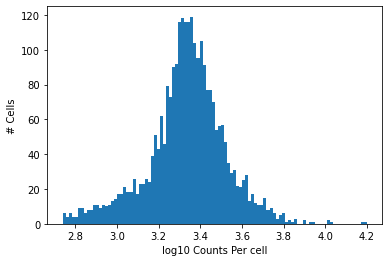

In [39]:
## plot log10 # counts per cell
plt.hist(np.log10(adata.obs['n_counts']), bins=100)
_ = plt.xlabel('log10 Counts Per cell')
_ = plt.ylabel('# Cells')

## Save the scanpy object to a file. This file will be passed as input to cNMF

In [40]:
count_adat_fn = 'example_PBMC/counts.h5ad'
sc.write(count_adat_fn, adata)

## In the cells below, we run the first 2 steps of cNMF assuming no parallelization:
    - prepare - normalizes the data for the run and specifies the input parameters
    - factorize - runs the actual factorization steps.
    
Refer to https://github.com/dylkot/cNMF to find tutorials incorporating paralellization.
## With the options below, this took roughly 4 minutes on our compute configuration. To speed this up on your own runs, you can run it only for K=7-8 as those are the only Ks we look in detail at in the steps below. See the commented out K variable in the below cell

In [43]:
numiter=20 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=2000 ## Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = 'example_PBMC/cNMF'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'pbmc_cNMF'

## Specify the Ks to use as a space separated list in this case "5 6 7 8 9 10"
K = ' '.join([str(i) for i in range(5,11)])

## To speed this up, you can run it for only K=7-8 with the option below
#K = ' '.join([str(i) for i in range(7,9)])


seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = 'example_PBMC/counts.h5ad'

In [48]:
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)

In [50]:
## Prepare the data, I.e. subset to 2000 high-variance genes, and variance normalize
cnmf_obj.prepare(counts_fn=countfn, components=np.arange(5,11), n_iter=20, seed=14, num_highvar_genes=2000)

/PHShome/mc1070/anaconda3/envs/cnmfdev_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [51]:
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
cnmf_obj.factorize(worker_i=0, total_workers=1)

[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[Worker 0]. Starting task 31.
[Worker 0]. Starting task 32.
[Worker 0]. Starting

/PHShome/mc1070/anaconda3/envs/cnmfdev_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


[Worker 0]. Starting task 97.
[Worker 0]. Starting task 98.
[Worker 0]. Starting task 99.
[Worker 0]. Starting task 100.
[Worker 0]. Starting task 101.
[Worker 0]. Starting task 102.
[Worker 0]. Starting task 103.
[Worker 0]. Starting task 104.
[Worker 0]. Starting task 105.
[Worker 0]. Starting task 106.
[Worker 0]. Starting task 107.
[Worker 0]. Starting task 108.
[Worker 0]. Starting task 109.
[Worker 0]. Starting task 110.
[Worker 0]. Starting task 111.
[Worker 0]. Starting task 112.


/PHShome/mc1070/anaconda3/envs/cnmfdev_env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


[Worker 0]. Starting task 113.
[Worker 0]. Starting task 114.
[Worker 0]. Starting task 115.
[Worker 0]. Starting task 116.
[Worker 0]. Starting task 117.
[Worker 0]. Starting task 118.
[Worker 0]. Starting task 119.


## Whether or not you used parallelization in the above steps, you should resume here with the combine step below which combines the individual factorization replicates so that the consensus estimate can be taken

In [52]:
cnmf_obj.combine()

Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.


## Compute the stability and error at each choice of K to see if a clear choice jumps out.

Please note that the maximum stability solution is not always the best choice depending on the application. However it is often a good starting point even if you have to investigate several choices of K

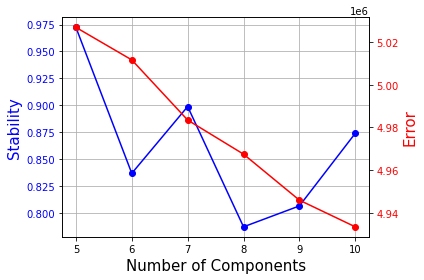

In [53]:
cnmf_obj.k_selection_plot(close_fig=False)

In [54]:
print('This saves the corresponding figure to the following file: %s' % cnmf_obj.paths['k_selection_plot'])

This saves the corresponding figure to the following file: example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.k_selection.png


## In this range, K=7 gave the most stable solution so we will begin by looking at that.

The next step computes the consensus solution for a given choice of K. We first run it without any outlier filtering to see what that looks like. Setting the density threshold to anything >= 2.00 (the maximum possible distance between two unit vectors) ensures that nothing will be filtered.

Then we run the consensus with a filter for outliers determined based on inspecting the histogram of distances between components and their nearest neighbors

In [68]:
selected_K = 7
density_threshold = 2.00

/PHShome/mc1070/anaconda3/envs/cnmfdev_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


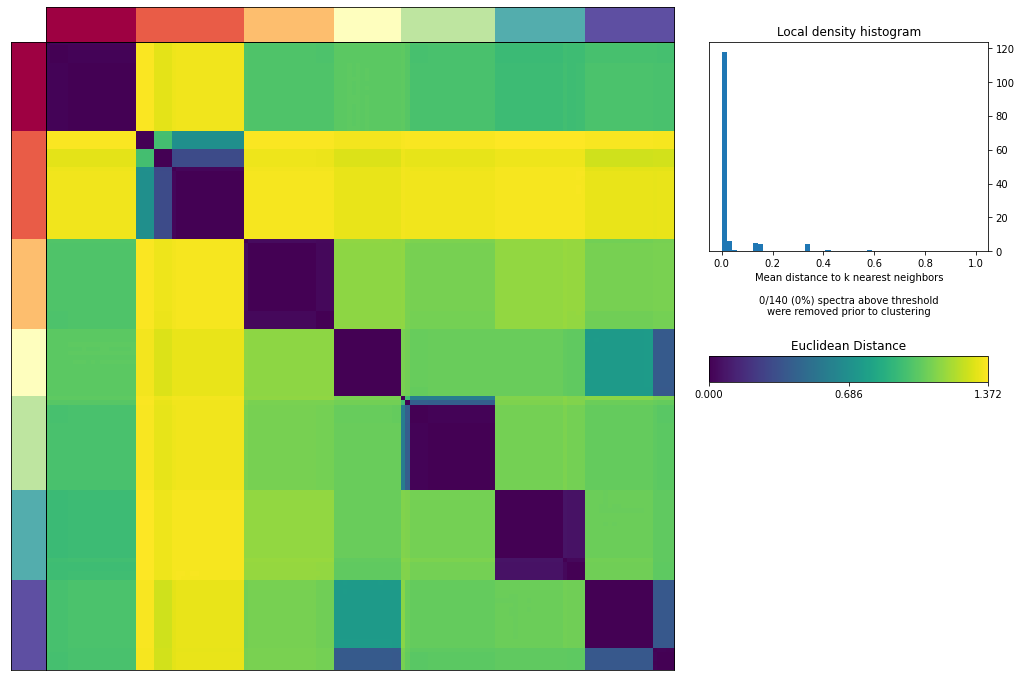

In [69]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False)

The output figure was saved to ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.clustering.k_7.dt_0_1.png so you can find it there if you ran the consensus step from the command line

The above consensus plot shows that there is a substantial degree of concordance between the replicates with a few outliers. An outlier threshold of 0.1 seems appropriate

In order to now output a reference for starCAT, we will set ```build_ref=True```

In [73]:
density_threshold = 0.10

/PHShome/mc1070/anaconda3/envs/cnmfdev_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


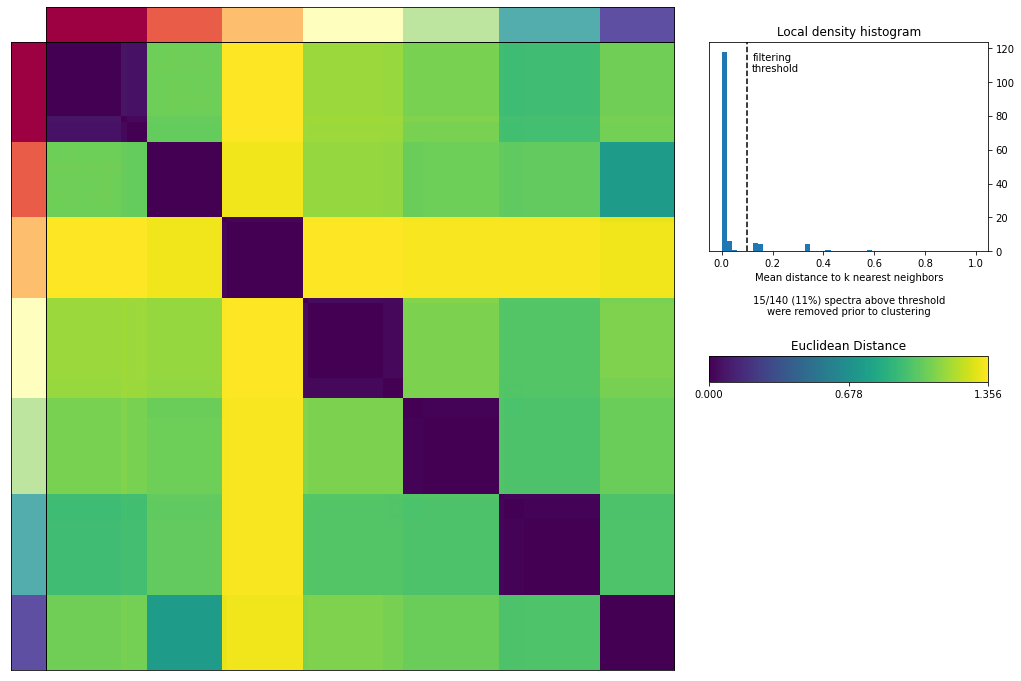

In [74]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=True, close_clustergram_fig=False,
                  build_ref=True)

Alternatively, we can build a reference after running consensus as follows:

```python
cnmf_obj.build_reference(k=selected_K, density_threshold=density_threshold)
```

## Now that we have completed the consensus step for cNMF, a number of output files have been outputted to look at

In [77]:
! ls ./example_PBMC/cNMF/pbmc_cNMF

cnmf_tmp
pbmc_cNMF.clustering.k_7.dt_0_05.png
pbmc_cNMF.clustering.k_7.dt_0_1.png
pbmc_cNMF.clustering.k_7.dt_2_0.png
pbmc_cNMF.gene_spectra_score.k_7.dt_0_05.txt
pbmc_cNMF.gene_spectra_score.k_7.dt_0_1.txt
pbmc_cNMF.gene_spectra_score.k_7.dt_2_0.txt
pbmc_cNMF.gene_spectra_tpm.k_7.dt_0_05.txt
pbmc_cNMF.gene_spectra_tpm.k_7.dt_0_1.txt
pbmc_cNMF.gene_spectra_tpm.k_7.dt_2_0.txt
pbmc_cNMF.k_selection.png
pbmc_cNMF.k_selection_stats.df.npz
pbmc_cNMF.overdispersed_genes.txt
pbmc_cNMF.spectra.k_7.dt_0_05.consensus.txt
pbmc_cNMF.spectra.k_7.dt_0_1.consensus.txt
pbmc_cNMF.spectra.k_7.dt_2_0.consensus.txt
pbmc_cNMF.starcat_spectra.k_7.dt_0_1.txt
pbmc_cNMF.usages.k_7.dt_0_05.consensus.txt
pbmc_cNMF.usages.k_7.dt_0_1.consensus.txt
pbmc_cNMF.usages.k_7.dt_2_0.consensus.txt


The reference spectra for our selected K and density threshold is here: 
- pbmc_cNMF.starcat_spectra.k_7.dt_0_1.txt


We can interpret the GEPs based on the top genes driving each GEP.

In [90]:
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)
topgenes.columns = ['GEP%d' % i for i in topgenes.columns]

In [95]:
topgenes.head(20)

,GEP1,GEP2,GEP3,GEP4,GEP5,GEP6,GEP7
0,RPS12,LYZ,CD74,NKG7,FCGR3A,RRM2,C2orf88
1,RPS27,S100A9,HLA-DRA,PRF1,FCER1G,CDC6,TSC22D1
2,RPS25,S100A8,HLA-DQB1,GZMB,LST1,MCM10,HIST1H2AC
3,EEF1A1,CST3,HLA-DQA1,GZMA,RP11-290F20.3,TYMS,AC147651.3
4,RPS15A,CD14,HLA-DPB1,GNLY,MS4A7,KIAA0101,LGALSL
5,RPL31,FCN1,HLA-DRB1,FGFBP2,IFITM3,CDC20,ACRBP
6,RPS6,TYROBP,CD79B,SPON2,IFITM2,TK1,PTCRA
7,RPS27A,LGALS2,HLA-DQA2,CST7,COTL1,KIFC1,MMD
8,RPLP2,GSTP1,MS4A1,CTSW,RHOC,BIRC5,ESAM
9,RPS3A,LGALS1,HLA-DPA1,CLIC3,AIF1,BLM,PRUNE


The GEPs roughly correspond to:

* 1 - T-cell identity
* 2 - CD14+ monocyte identity
* 3 - B-cell identity
* 4 - NK-cell identity
* 5 - CD16+ monocyte identity
* 6 - Cell cycle activity
* 7 - Myeloid identity

We can then use them to annotate a new dataset.

## Download separate query data and copy it to the directory ./query_PBMC

In [78]:
! wget -O query_PBMC/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.tar.gz https://cf.10xgenomics.com/samples/cell-exp/4.0.0/Parent_NGSC3_DI_PBMC/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.tar.gz
! tar -zxvf query_PBMC/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.tar.gz    
! mv filtered_feature_bc_matrix query_PBMC
! rm  query_PBMC/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.tar.gz

--2024-05-20 14:10:58--  https://cf.10xgenomics.com/samples/cell-exp/4.0.0/Parent_NGSC3_DI_PBMC/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com|104.18.0.173|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 92815798 (89M) [application/x-tar]
Saving to: “query_PBMC/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.tar.gz”

100%[======================================>] 92,815,798  15.2M/s   in 5.9s    

2024-05-20 14:11:05 (15.1 MB/s) - “query_PBMC/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.tar.gz” saved [92815798/92815798]

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/barcodes.tsv.gz


## Run starCAT on query

In [81]:
tcat = starCAT(reference='./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.starcat_spectra.k_7.dt_0_1.txt', 
               cachedir='./query_PBMC/cache')

Using user specified reference spectra file ./example_PBMC/cNMF/pbmc_cNMF/pbmc_cNMF.starcat_spectra.k_7.dt_0_1.txt
No scores provided


In [85]:
tcat.ref

,ISG15,CPSF3L,MRPL20,ATAD3C,C1orf86,RER1,TNFRSF25,CAMTA1,TNFRSF9,ENO1,...,PRMT2,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP6,MT-CO3,MT-ND4,MT-ND5,MT-CYB
GEP1,0.213573,0.059395,0.291212,0.000000,0.192421,0.119510,0.232727,0.137690,0.025416,0.381694,...,0.293640,0.909563,1.230623,1.103495,0.801094,0.645041,1.143398,1.330294,0.339570,1.030652
GEP2,1.040371,0.017063,0.421599,0.000000,0.514873,0.224933,0.000000,0.159497,0.055715,0.688915,...,0.128932,1.815674,0.611675,2.032145,0.815297,0.770144,1.097263,0.888587,0.367350,0.952296
GEP3,0.193707,0.250315,0.198822,0.000000,0.258690,0.206760,0.000000,0.205168,0.000000,0.190324,...,0.012787,0.983346,0.902678,1.764107,0.856400,0.561714,1.415078,1.373947,0.257519,0.819548
GEP4,0.516527,0.102063,0.334910,0.383978,0.232708,0.308342,0.057103,0.121057,0.219432,0.706243,...,0.861041,0.830861,1.007107,1.948806,1.014349,0.913621,1.299510,1.255432,0.372176,0.915217
GEP5,1.538717,0.027625,0.247977,0.000000,0.203778,0.286007,0.026766,0.122523,0.000000,0.694238,...,0.247758,1.059718,1.055433,2.310755,1.349492,0.731056,1.077800,1.155318,0.407248,0.636162
GEP6,0.416025,0.017946,0.354892,0.000000,0.233847,0.499674,0.116113,0.374859,0.078547,2.124893,...,0.027216,0.615830,0.000000,1.269225,0.000000,0.000000,1.004581,0.346307,0.430923,0.000000
GEP7,0.134771,0.012192,0.008382,0.000000,0.016016,0.000000,0.000000,2.894347,0.026261,0.344913,...,0.605626,1.070769,0.930944,0.742003,0.741356,1.840834,0.806375,0.539854,0.266425,0.966455


In [86]:
# Load query counts data
adata = tcat.load_counts('./query_PBMC/filtered_feature_bc_matrix/matrix.mtx.gz')

In [97]:
# Run starCAT 
usage, _ = tcat.fit_transform(adata)

1840 out of 2000 genes in the reference overlap with the query


In [107]:
usage

,GEP1,GEP2,GEP3,GEP4,GEP5,GEP6,GEP7
AAACCCACATAACTCG-1,0.555852,0.171307,0.055815,0.059038,0.033111,0.119420,0.005457
AAACCCACATGTAACC-1,0.322750,0.000160,0.559939,0.039901,0.000076,0.069805,0.007368
AAACCCAGTGAGTCAG-1,0.155966,0.127428,0.241674,0.068205,0.239079,0.160350,0.007298
AAACCCAGTGCTTATG-1,0.827537,0.000166,0.052788,0.076342,0.000711,0.032717,0.009740
AAACGAACAGTCAGTT-1,0.261713,0.243788,0.150268,0.150840,0.052973,0.125293,0.015126
...,...,...,...,...,...,...,...
TTTGTTGGTCCGTACG-1,0.309050,0.316715,0.111934,0.054564,0.106098,0.086757,0.014882
TTTGTTGGTCGGAACA-1,0.835987,0.000323,0.033394,0.018343,0.000112,0.104722,0.007119
TTTGTTGGTTTACGAC-1,0.885994,0.000487,0.037010,0.010578,0.000137,0.061216,0.004578
TTTGTTGTCGTTATCT-1,0.219369,0.078509,0.105357,0.091927,0.367954,0.129679,0.007205


By default, pre-built reference spectra and scores files are cached, and specifying score path is not necessary. If score add-ons for custom references are desired, pass a filepath to the custom scores.yaml file during initialization of the *CAT object.

Please refer to example references (ex. TCAT.V1) for formatting of the scores file and related files. The scores file should be a yaml file defining relevant weighted linear combinations of GEPs in defining a score (ex. 3 GEPs summed to define Cell Cycle score). It also may include may include code blocks for other types of calculations of scores. Any files referenced by the scores file should be present within the same directory.

An example file structure for TCAT.V1:

```
--TCAT.V1
---TCAT.V1.reference.tsv
---TCAT.V1.scores.yaml
---TCAT.V1.MultiLogRegression.pkl
---multinomial_lineage_classifier.py
```